**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

Thanks  Prerit Jaiswal ,who brings me some ideas and some useful methods.
https://github.com/preritj/Vechicle-Detection-Tracking.git

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: uint8


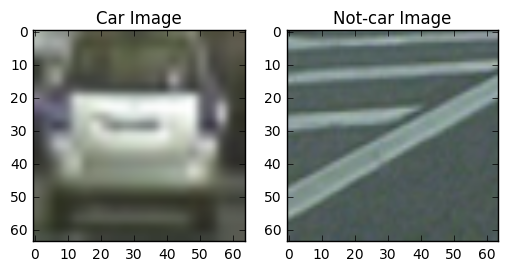

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os

%matplotlib inline

#from skimage.feature import hog
#from skimage import color, exposure
#images are divided up into vehicles and non-vehicles
cars=glob.glob('vehicles/*/*.*')
notcars=glob.glob('non-vehicles/*/*.*')
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = cv2.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = cv2.imread(cars[car_ind])
notcar_image = cv2.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Not-car Image')
plt.savefig('output_images/car_not_car.png')

In [23]:
# Define a function to return HOG features and visualization
# Features will always be the first element of the return
# Image data will be returned as the second element if visualize= True
# Otherwise there is no second return element
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True):                  
    # TODO: Complete the function body and returns
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,block_norm = 'L1-sqrt', 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,block_norm = 'L1-sqrt',
                       visualise=vis, feature_vector=feature_vec)
        return features

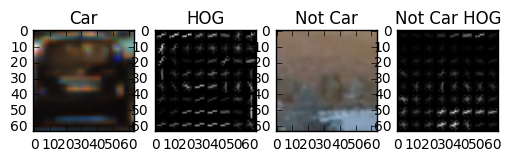

In [24]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog

# Generate a random index to look at a car image
car_ind = np.random.randint(0, len(cars))
not_car_ind = np.random.randint(0, len(notcars))

# Read in the image
car_image =  cv2.imread(cars[car_ind])
not_car_image =  cv2.imread(notcars[not_car_ind])

car_gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
not_car_gray = cv2.cvtColor(not_car_image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
car_features, car_hog_image = get_hog_features(car_gray, orient= 9, pix_per_cell= 8, cell_per_block= 2, vis=True, feature_vec=True)
not_car_features, not_car_hog_image = get_hog_features(not_car_gray, orient= 9, pix_per_cell= 8, cell_per_block= 2, vis=True, feature_vec=True)


# Plot the examples
fig = plt.figure()
plt.subplot(141)
plt.imshow(car_image, cmap='gray')
plt.title('Car')
plt.subplot(142)
plt.imshow(car_hog_image, cmap='gray')
plt.title('HOG')
plt.subplot(143)
plt.imshow(not_car_image, cmap='gray')
plt.title('Not Car')
plt.subplot(144)
plt.imshow(not_car_hog_image, cmap='gray')
plt.title('Not Car HOG')
plt.savefig('output_images/HOG_example.png')

In [25]:
from sklearn.model_selection import train_test_split

# split vehicles data by selecting tracks manually for GTI data and randomly for KITTI data
# given by Prerit Jaiswal
car_train_indices = []
car_test_indices = []

def split_manual(DIR, indices):
    start,stop = indices
    img_files = glob.glob(os.path.join(DIR,"*.*"))
    for f in img_files :
        index = int(f.split("image")[1][:4])
        if start<=index<=stop :
            car_test_indices.append(cars.index(f))
        else :
            car_train_indices.append(cars.index(f))
            
def split_random(DIR, test_size=0.2) :
    img_files = glob.glob(os.path.join(DIR,"*.*"))
    train,test = train_test_split(img_files, test_size=test_size, random_state=0)
    car_train_indices.extend([cars.index(f) for f in train])
    car_test_indices.extend([cars.index(f) for f in test])

split_manual("vehicles/GTI_Far/", (605,799))
split_manual("vehicles/GTI_Left/", (9,183))
split_manual("vehicles/GTI_Far/", (191,397))
split_manual("vehicles/GTI_Far/", (803,974))
test_size = 1/(1+len(car_train_indices)/len(car_test_indices))
split_random("vehicles/KITTI_extracted/", test_size=test_size)
print("Number of images in vehicles training set : ", len(car_train_indices))
print("Number of images in vehicles test set : ", len(car_test_indices))
print("Test size is {:2.2f}% of total vehicles dataset".format(
        100/(1+len(car_train_indices)/len(car_test_indices))))
print("="*50)

# split non-vehicles data through random split
img_files = glob.glob(os.path.join("non-vehicles/*/*.*"))
notcar_train_indices, notcar_test_indices = train_test_split(range(len(notcars)), test_size=test_size,
                                                            random_state=0)
print("Number of images in non-vehicles training set : ", len(notcar_train_indices))
print("Number of images in non-vehicles test set : ", len(notcar_test_indices))
print("Test size is {:2.2f}% of total non-vehicles dataset".format(
        100/(1+len(notcar_train_indices)/len(notcar_test_indices))))

Number of images in vehicles training set :  7540
Number of images in vehicles test set :  1837
Test size is 19.59% of total vehicles dataset
Number of images in non-vehicles training set :  7211
Number of images in non-vehicles test set :  1757
Test size is 19.59% of total non-vehicles dataset


In [26]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space == 'RGB':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        elif color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else: feature_image = np.copy(image)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return np.array(features)

def SVC_HOG(color_space="RGB", orient=9, pix_per_cell=8, cell_per_block=2, 
            hog_channel="ALL",debug=True) :
    t=time.time()
    car_features = extract_features(cars, color_space=color_space, orient=orient, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, hog_channel=hog_channel)
    notcar_features = extract_features(notcars, color_space=color_space, orient=orient, pix_per_cell=pix_per_cell, 
                                       cell_per_block=cell_per_block, hog_channel=hog_channel)
    t2 = time.time()
    if debug :
        print(round(t2-t, 2), 'Seconds to extract HOG features...')
    # Create an array stack of feature vectors and normalize
    X_train = np.vstack((car_features[car_train_indices], 
                         notcar_features[notcar_train_indices])).astype(np.float64)   
    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = np.vstack((car_features[car_test_indices], 
                         notcar_features[notcar_test_indices])).astype(np.float64) 
    X_test = standard_scaler.transform(X_test) # use same fit as training data

    # labels vector
    y_train = np.hstack((np.ones(len(car_train_indices)), np.zeros(len(notcar_train_indices))))
    y_test = np.hstack((np.ones(len(car_test_indices)), np.zeros(len(notcar_test_indices))))

    if debug :
        print('Using:',orient,'orientations',pix_per_cell,
            'pixels per cell and', cell_per_block,'cells per block')
        print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    if debug :
        print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

In [27]:
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" 
color_space = "YUV"

SVC_HOG(color_space=color_space, orient=orient,
        cell_per_block=cell_per_block, hog_channel=hog_channel, debug=True)

99.1 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
16.56 Seconds to train SVC...
Test Accuracy of SVC =  0.9958


In [28]:
orient=9
pix_per_cell=8
cell_per_block=2
hog_channel="ALL" 
color_spaces = ["RGB","HSV","LUV","HLS","YUV","YCrCb"]


for color_space in color_spaces:
    print("="*50)
    print("Color space : ", color_space)
    SVC_HOG(color_space=color_space, orient=orient, pix_per_cell=pix_per_cell, 
        cell_per_block=cell_per_block, hog_channel=hog_channel,debug=False)
    

Color space :  RGB
Test Accuracy of SVC =  0.9819
Color space :  HSV
Test Accuracy of SVC =  0.9953
Color space :  LUV
Test Accuracy of SVC =  0.9942
Color space :  HLS
Test Accuracy of SVC =  0.9955
Color space :  YUV
Test Accuracy of SVC =  0.9958
Color space :  YCrCb
Test Accuracy of SVC =  0.9967


In [29]:
pix_per_cell=8
cell_per_block=2
hog_channel="ALL" # options : 0,1,2,"ALL"
color_space="YCrCb"

for orient in [8,9,10,11] :
        print("="*50)
        print("Orientation bins : ", orient)
        print("="*50)
        SVC_HOG(color_space=color_space, orient=orient, pix_per_cell=pix_per_cell, 
        cell_per_block=cell_per_block, hog_channel=hog_channel,debug=False)

Orientation bins :  8
Test Accuracy of SVC =  0.9947
Orientation bins :  9
Test Accuracy of SVC =  0.9967
Orientation bins :  10
Test Accuracy of SVC =  0.9958
Orientation bins :  11
Test Accuracy of SVC =  0.9969


In [31]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=[(0, 256)]*3, visualize=False):
    channel_hist = [np.histogram(img[:,:,i], bins=nbins, range=bins_range[i]) for i in range(img.shape[2])]
    bin_edges = [hist[1] for hist in channel_hist]
    channel_hist = [hist[0] for hist in channel_hist]
    hist_features = np.concatenate(channel_hist)
    if visualize :
        return (channel_hist, bin_edges, hist_features) 
    else :
        return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb) 
        elif color_space == 'RGB':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else: 
            break
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return np.array(features)
def SVC_COLOR(color_space="RGB", spatial=32, histbin=32, hist_range=[(0, 256)]*3,debug=True) :
    t=time.time()
    car_features = extract_features(cars, color_space=color_space, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=hist_range)
    notcar_features = extract_features(notcars, color_space=color_space, spatial_size=(spatial, spatial),
                            hist_bins=histbin, hist_range=hist_range)
    t2 = time.time()
    if debug :
        print(round(t2-t, 2), 'Seconds to extract HOG features...')
    
    # Create an array stack of feature vectors and normalize
    X_train = np.vstack((car_features[car_train_indices],notcar_features[notcar_train_indices])).astype(np.float64)   
    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = np.vstack((car_features[car_test_indices],notcar_features[notcar_test_indices])).astype(np.float64) 
    X_test = standard_scaler.transform(X_test) # use same fit as training data

    # labels vector
    y_train = np.hstack((np.ones(len(car_train_indices)), np.zeros(len(notcar_train_indices))))
    y_test = np.hstack((np.ones(len(car_test_indices)), np.zeros(len(notcar_test_indices))))

    if debug :
        print('Using:',orient,'orientations',pix_per_cell,
            'pixels per cell and', cell_per_block,'cells per block')
        print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

In [32]:
spatial = 32
histbin = 32
color_space = "YCrCb"

SVC_COLOR(color_space=color_space, spatial=spatial, histbin=histbin, debug=True)

21.92 Seconds to extract HOG features...
Using: 11 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 3168
17.13 Seconds to train SVC...
Test Accuracy of SVC =  0.9686


In [33]:
#chose YCrCb color space
'''
spatial = 32
histbin = 32
color_spaces = ["RGB","HSV","LUV","HLS","YUV","YCrCb"]

for color_space in color_spaces:
    print("="*50)
    print("Color space : ", color_space)
    SVC_COLOR(color_space=color_space, spatial=spatial, histbin=histbin, debug=False)
'''

'\nspatial = 32\nhistbin = 32\ncolor_spaces = ["RGB","HSV","LUV","HLS","YUV","YCrCb"]\n\nfor color_space in color_spaces:\n    print("="*50)\n    print("Color space : ", color_space)\n    SVC_COLOR(color_space=color_space, spatial=spatial, histbin=histbin, debug=False)\n'

In [34]:
color_space = "YCrCb"

for spatial in [8,16,32] :
    for histbin in [16,32,64] :
        print("="*50)
        print("Number of spatial bins : ", spatial)
        print("Number of color histogram bins : ", histbin)
        SVC_COLOR(color_space=color_space, spatial=spatial, histbin=histbin, debug=False)


Number of spatial bins :  8
Number of color histogram bins :  16
5.12 Seconds to train SVC...
Test Accuracy of SVC =  0.9647
Number of spatial bins :  8
Number of color histogram bins :  32
4.37 Seconds to train SVC...
Test Accuracy of SVC =  0.9691
Number of spatial bins :  8
Number of color histogram bins :  64
4.12 Seconds to train SVC...
Test Accuracy of SVC =  0.9755
Number of spatial bins :  16
Number of color histogram bins :  16
6.43 Seconds to train SVC...
Test Accuracy of SVC =  0.9674
Number of spatial bins :  16
Number of color histogram bins :  32
4.66 Seconds to train SVC...
Test Accuracy of SVC =  0.9727
Number of spatial bins :  16
Number of color histogram bins :  64
4.13 Seconds to train SVC...
Test Accuracy of SVC =  0.9794
Number of spatial bins :  32
Number of color histogram bins :  16
19.39 Seconds to train SVC...
Test Accuracy of SVC =  0.9638
Number of spatial bins :  32
Number of color histogram bins :  32
16.91 Seconds to train SVC...
Test Accuracy of SVC =  

Number of spatial bins is 16 and Number of color histogram bins is 64

In [35]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True,block_norm = 'L1-sqrt', 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True,block_norm = 'L1-sqrt', 
                       visualise=vis, feature_vector=feature_vec)
        return features
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel()
    return features

# function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=[(0, 256)]*3, visualize=False):
    channel_hist = [np.histogram(img[:,:,i], bins=nbins, range=bins_range[i]) for i in range(img.shape[2])]
    bin_edges = [hist[1] for hist in channel_hist]
    #bin_centers = (bin_edges[1:]  + bin_edges[:-1])/2
    channel_hist = [hist[0] for hist in channel_hist]
    hist_features = np.concatenate(channel_hist)
    if visualize :
        return (channel_hist, bin_edges, hist_features) 
    else :
        return hist_features
def extract_features(imgs):
    # parameters
    orient=11
    pix_per_cell=8
    cell_per_block=2
    spatial_size=(16, 16)
    hist_bins=64
    color="YCrCb"    
    features = []
    for file in imgs:
        image = cv2.imread(file)
        feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # HOG features
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)
        # spatial and color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # combine all features
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    return np.array(features)

In [36]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler


t=time.time()
car_features = extract_features(cars)
notcar_features = extract_features(notcars)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract all features...')

# Create an array stack of feature vectors and normalize
X_train = np.vstack((car_features[car_train_indices],notcar_features[notcar_train_indices])).astype(np.float64)   
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_test = np.vstack((car_features[car_test_indices],notcar_features[notcar_test_indices])).astype(np.float64) 
X_test = standard_scaler.transform(X_test) # use same fit as training data

# labels vector
y_train = np.hstack((np.ones(len(car_train_indices)), np.zeros(len(notcar_train_indices))))
y_test = np.hstack((np.ones(len(car_test_indices)), np.zeros(len(notcar_test_indices))))

print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
#svc = LinearSVC()
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(LinearSVC(), param_grid={'C':np.logspace(-3,-2,5)})
# Check the training time for the SVC
t=time.time()
clf = clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print("CV results : ", clf.best_estimator_)

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))

122.56 Seconds to extract all features...
Feature vector length: 7428
163.69 Seconds to train SVC...
CV results :  LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Test Accuracy of SVC =  0.9947


In [41]:
def find_cars(img, ystart, ystop, scale, clf, X_scaler):
    # parameters
    orient=11
    pix_per_cell=8
    cell_per_block=2
    spatial_size=(16, 16)
    hist_bins=64
    color="YCrCb"    
    cvt_color = cv2.COLOR_BGR2RGB
    bins_range = [(0,256)]*3 

    #img = img.astype(np.float32)/255
    draw_img = np.copy(img)
    
    
    img_tosearch = img[ystart:ystop,:,:]
    img_tosearch = cv2.cvtColor(img_tosearch, cvt_color)
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = img_tosearch[:,:,0]
    ch2 = img_tosearch[:,:,1]
    ch3 = img_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list=[]
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins,bins_range=bins_range)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features,
                                                          hog_features)).reshape(1, -1)) 
            test_prediction = clf.predict(test_features)
            confidence = clf.decision_function(test_features)
            if test_prediction == 1 and confidence>0.3:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart),
                              (0,0,1),6)
                bbox_list.append(((xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return bbox_list



def draw_boxes(img, bbox_list, color=(0,0,255)):
    for box in bbox_list :
        cv2.rectangle(img, box[0], box[1], color,6)
    return img
    

# sliding window scales and the search y-range
y_range = {1.0 : (380,508), 
           1.5 : (380,572), 
           2.0 : (380,636), 
           2.5 : (380,700)}

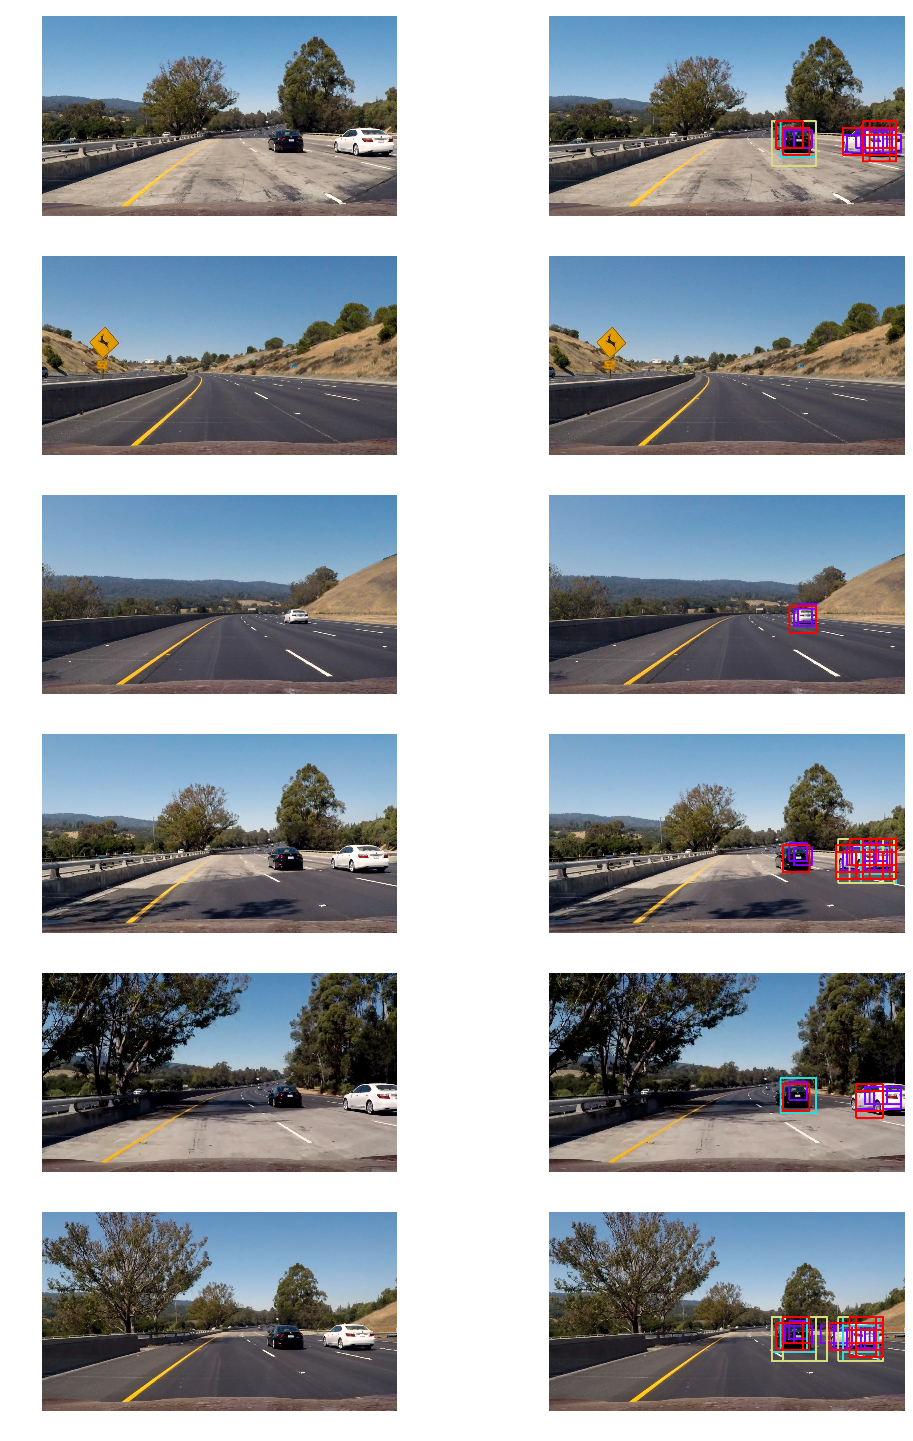

In [42]:
test_imgs = glob.glob("test_images/*.jpg")
nrows = len(test_imgs)
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 3*nrows))
for ax in axes.flatten():
    ax.axis('off')
for image, ax in zip(test_imgs, axes):
    img = cv2.imread(image)
    out_img = np.copy(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    for scale, i_color in zip(y_range.keys(), np.linspace(0,1,4)) :
        ystart,ystop = y_range[scale]
        color = tuple(255*c for c in plt.cm.rainbow(i_color)[:3])
        bbox_list = find_cars(img, ystart, ystop, scale, clf, standard_scaler)
        out_img = draw_boxes(out_img, bbox_list,color)
    ax[1].imshow(out_img)

In [43]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


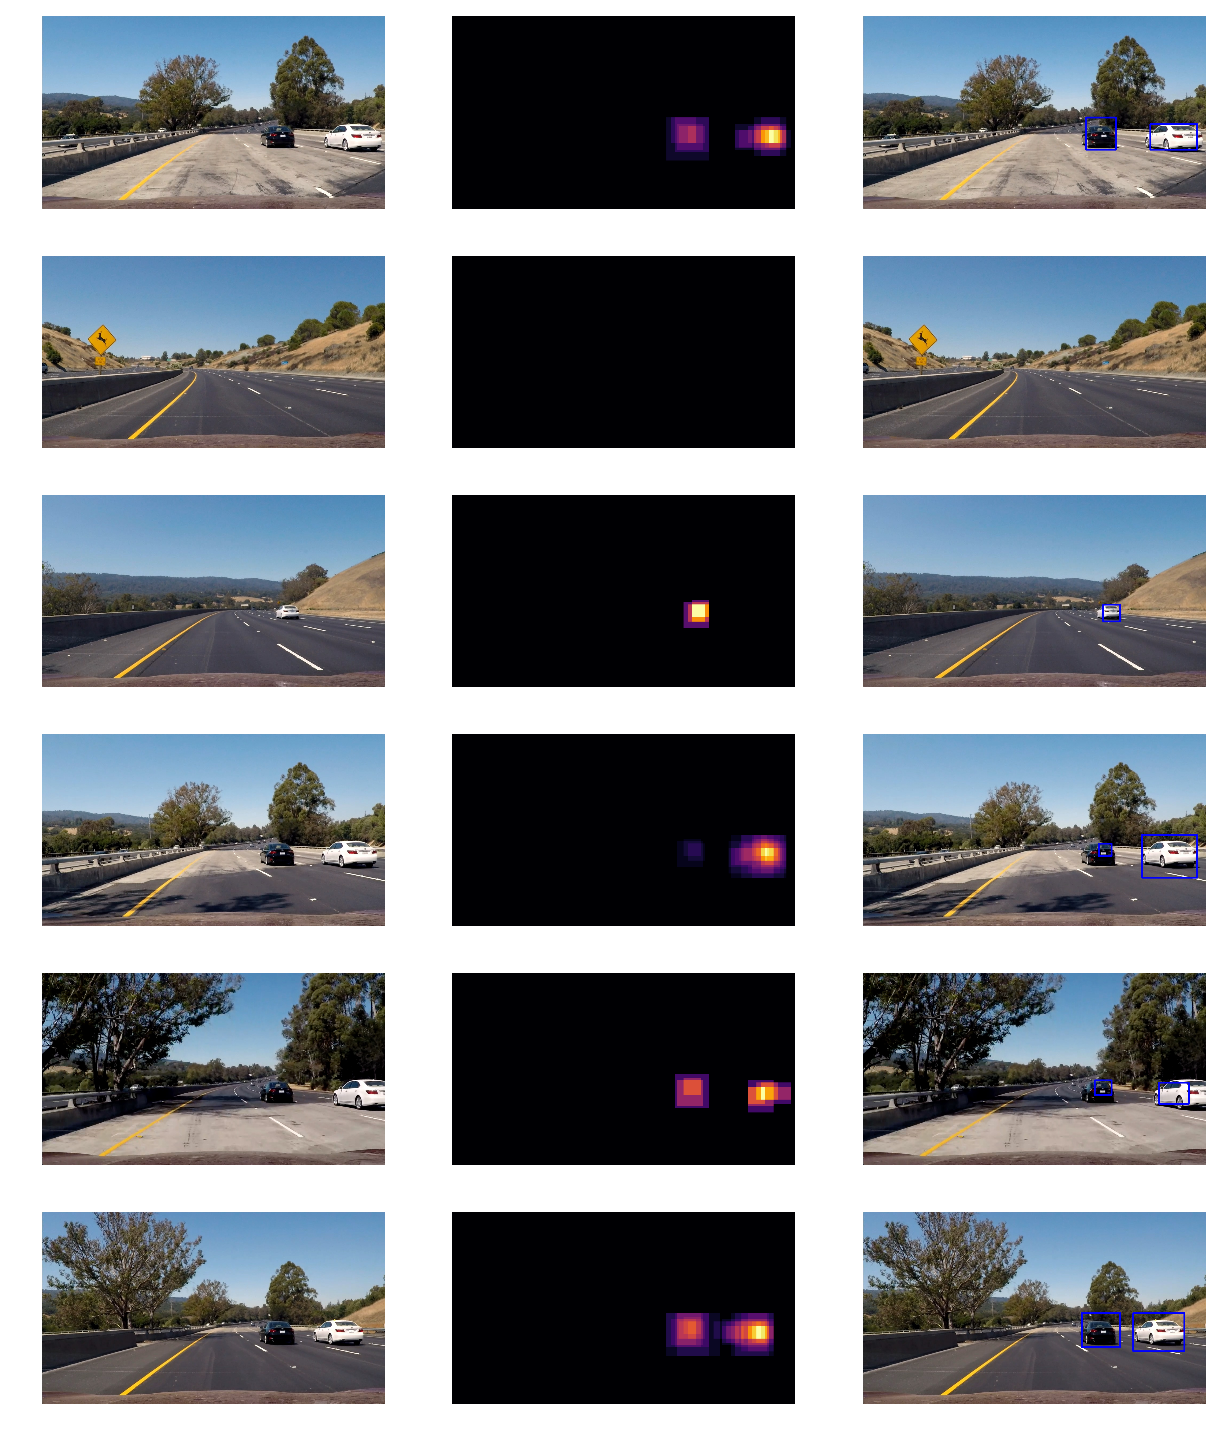

In [44]:
from scipy.ndimage.measurements import label


test_imgs = glob.glob("test_images/*.jpg")
nrows = len(test_imgs)
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 3*nrows))
for ax in axes.flatten():
    ax.axis('off')
for image, ax in zip(test_imgs, axes):
    img = cv2.imread(image)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    out_img = np.copy(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    for scale, i_color in zip(y_range.keys(), np.linspace(0,1,len(y_range))) :
        ystart,ystop = y_range[scale]
        bbox_list = find_cars(img, ystart, ystop, scale, clf, standard_scaler)
        out_img = draw_boxes(out_img, bbox_list,color)
        heat = add_heat(heat,bbox_list)
    ax[1].imshow(heat, cmap=plt.cm.inferno)
    heat = apply_threshold(heat,2)  
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), labels)
    ax[2].imshow(draw_img)

In [45]:
from matplotlib import cm
# given by Prerit Jaiswal, the out_display is very useful to adjust parameters
video_dim = (1280, 720)
class vehicle_detection :
    def __init__(self, n_iter=25, n_update=2, threshold=2) :
        self.count = 0
        # bboxes for every frame
        self.out_img = None
        # labeled bboxes 
        self.out_img_labeled = None
        # vehicle labels 
        self.labels = [None,0]
        # list of bbox lists from last n iterations
        self.bbox_list_n = [] 
        # number of frames to smooth over
        self.n_iter = n_iter
        # number of frames after which to update detection
        self.n_update = n_update
        # threshold for heat map
        self.threshold = threshold
        # heat map
        self.heat = np.zeros(video_dim[::-1])
        self.heatmap = np.copy(self.heat)
    
    def process_image(self, image) :
        self.count += 1
        self.image=image
        out_img = np.copy(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        for scale, i_color in zip(y_range.keys(), np.linspace(0,1,len(y_range))) :
            ystart,ystop = y_range[scale]
            bbox_list = find_cars(img, ystart, ystop, scale, clf, standard_scaler)
            color = tuple(255*c for c in plt.cm.rainbow(i_color)[:3])
            self.out_img = draw_boxes(out_img, bbox_list,color)
        self.bbox_list_n.append(bbox_list)
        if self.count%self.n_update == 0 :
            for bbox_list in self.bbox_list_n :
                self.heat = add_heat(self.heat,bbox_list)
            self.heat = apply_threshold(self.heat,self.threshold)
            self.heatmap = np.clip(self.heat, 0, 255)
            self.labels = label(self.heatmap)
            self.heat = np.clip(self.labels[0],0,1)*2
        if len(self.bbox_list_n)>self.n_iter :
            self.bbox_list_n.pop(0)
        self.out_img_labeled = draw_labeled_bboxes(np.copy(image), self.labels)
        return self.out_display()
    

    def out_display(self) :
        imgA = cv2.resize(self.out_img, None, fx=0.4, fy=0.4, interpolation=cv2.INTER_AREA)
        imgB = np.uint8(self.heatmap*255/(0.001+np.max(self.heatmap)))
        imgB = cm.inferno(imgB)[:,:,:3]*255
        imgB = imgB.astype(np.uint8)
        imgB = cv2.addWeighted(imgB, 1, self.image, 0.4, 0)
        imgB = cv2.resize(imgB, None, fx=0.4, fy=0.4, interpolation=cv2.INTER_AREA)
        hA,wA = imgA.shape[:2]
        h_text = int(video_dim[1]/2-hA)
        textA = np.zeros((h_text, wA,3), dtype=np.uint8)
        textB = np.zeros((video_dim[1]-h_text-2*hA, wA,3), dtype=np.uint8)
        textA[:,:,1] = 200
        textB[:,:,1] = 200
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(textA,'Bounding boxes',(10,h_text-20), font,1,(0,0,0),3,cv2.LINE_AA)
        cv2.putText(textB,'Heatmap',(10,h_text-20), font,1,(0,0,0),3,cv2.LINE_AA)
        img_combined_right = np.vstack((textA,imgA,textB,imgB))
        return np.hstack((self.out_img_labeled, img_combined_right))

In [46]:
vd = vehicle_detection()
def process(image):
    return vd.process_image(image)

In [47]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [27:11<00:01,  1.18s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 25min 6s, sys: 1min 27s, total: 26min 34s
Wall time: 27min 13s


In [48]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))